# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### *Data Problem definition*

Develop a machine learning model to predict car price of a used car (that a user is willing to pay) based on the features of the car. The target of the model would be the car price. Additional part of the problem is to understand which features have most impact on the target of the model.

Analyze different regression models and pick the best model by using MSE and MAE for validating the predictions and performance of the models. Use grid search to optimize the parameters towards finding the best model


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [70]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn import set_config
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [35]:
vehicles_df = pd.read_csv('data/vehicles.csv')

In [36]:
vehicles_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [37]:
vehicles_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [38]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

## Data Exploration

### Initial exploration 

Some of the columns can be eliminated right away from analysis as they are likely not useful. Some explanation on why I am not including the following columns:

**'id'**: this is just an identifier and does not capture a feature of the vehicle

**'region'**: this could be impactful but given these are all in the US, and the number of unique values are large, analyzing this can become complex with little benefit

**'VIN'**: is another identifier that does not capture any useful information about the car

**'paint_color'**: could be useful but likely will have less impact

**'state'**: same reasoning as region

**'model'**: will also drop the model column to make the analysis simpler, even though model likely has a direct impact on price because of branding. This column has too many string values which will complicate the training a lot especially when using onehotencoder for this. 

### Further exploration

Analyzing other columns. Looking at the spread of the columns among its different values. The initial idea is that if most of the rows have the same value, it may not be useful. For example, if we take an extreme case, if all vehicles are of fuel type gas, it does not provide useful information

For 9 of the following columns we plot the counts against values and look for skews and outliers

In [39]:
# analyze remaining object columns

columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 
           'transmission', 'drive', 'size', 'type']
value_counts = [vehicles_df[column].value_counts() for column in columns]


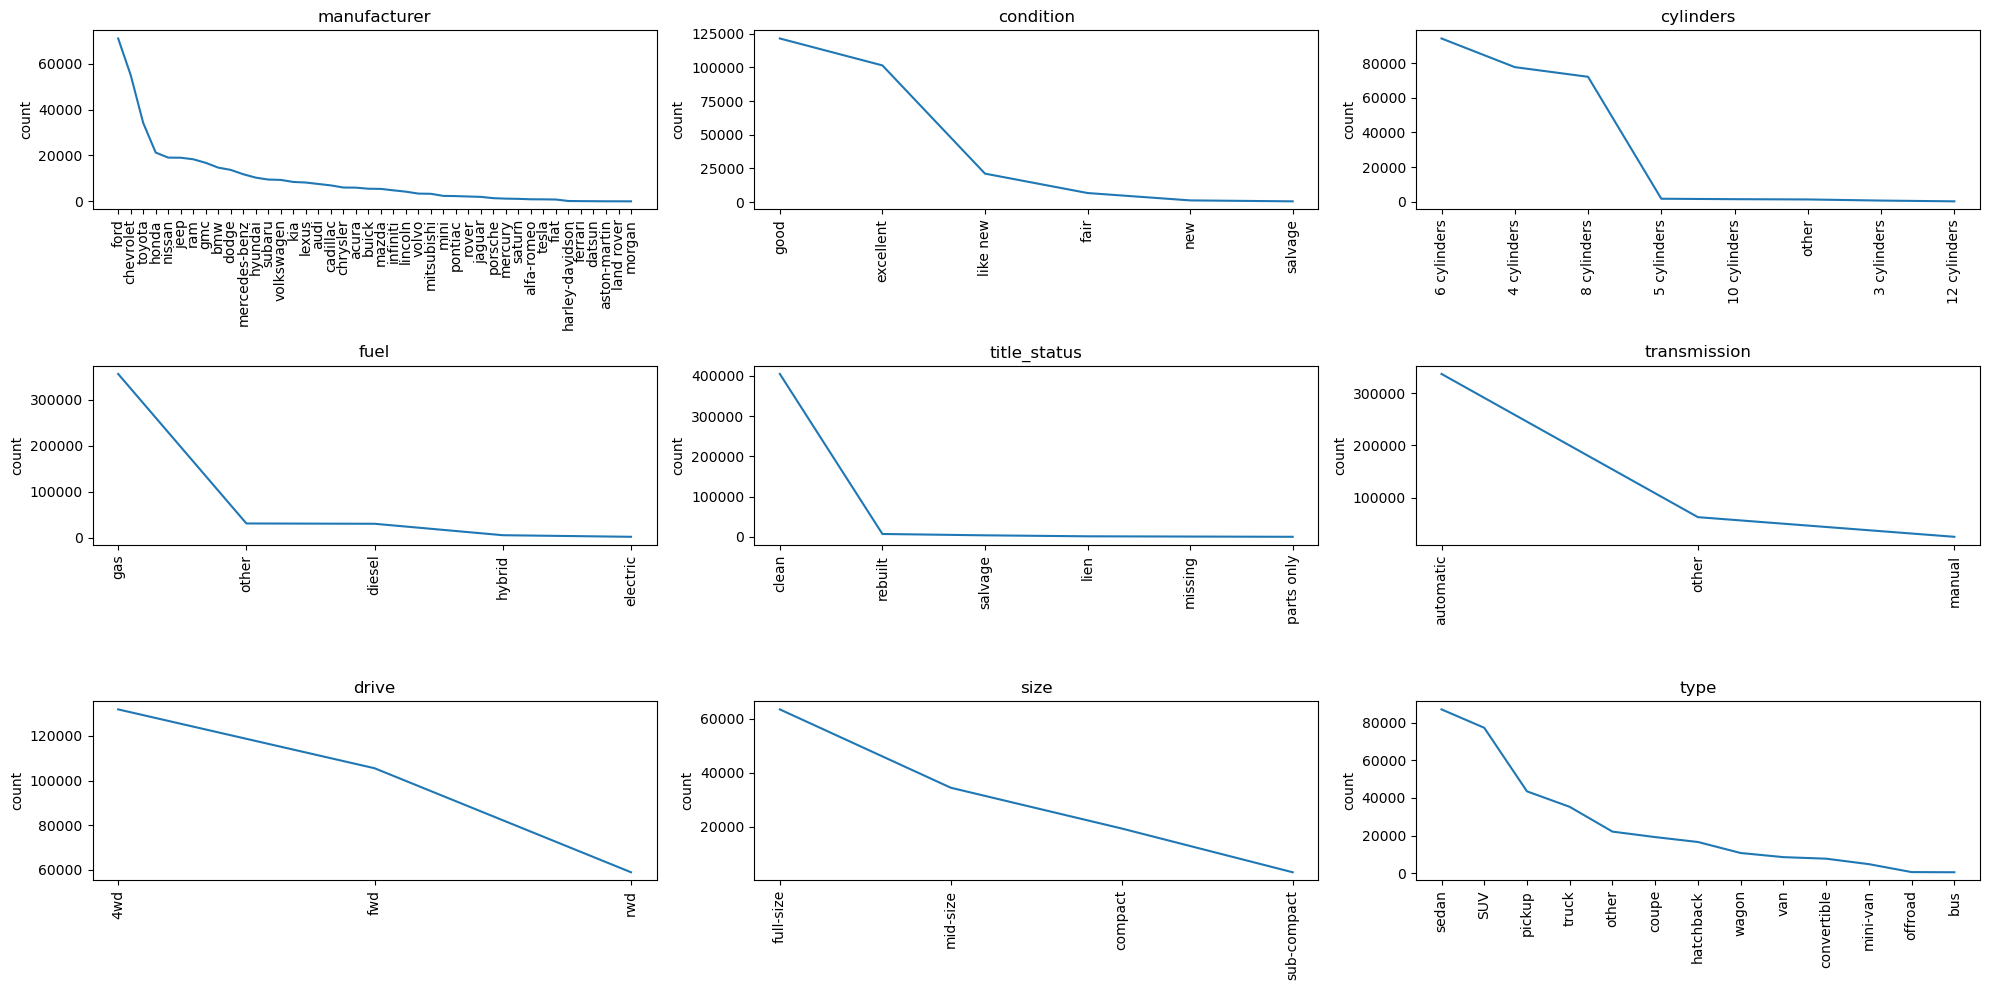

In [40]:
# visualize counts of the vehicles for each value of specific column
fig, axs = plt.subplots(3, int(len(columns) / 3), figsize=(20,10))

for i in range(0, len(columns)):
    x, y = int(i/3), int(i%3)
    axs[x, y].plot(value_counts[i])
    axs[x, y].set_title(columns[i])
    axs[x, y].set_ylabel('count')
    axs[x, y].set_xticks(range(len(value_counts[i].index)))
    axs[x, y].set_xticklabels(value_counts[i].index, rotation=90)
    
plt.tight_layout()
plt.show()

### Further exploration (conclusion)

From above it is clear that the following columns do not provide a lot of value:

**'title_status'**: most of the vehicles are in clean state and there is very little variance

**'fuel'**: most of the vehicles are gas, and there is very little variance


In [77]:
# look at remaining columns and analyze further
clean_df = vehicles_df.drop(['id', 'region', 'VIN', 'paint_color', 'state', 'title_status', 'fuel'], axis=1)

In [78]:
# check to see how many rows get dropped if we remove all rows with missing values
clean_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 31 to 426836
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         82051 non-null  int64  
 1   year          82051 non-null  float64
 2   manufacturer  82051 non-null  object 
 3   model         82051 non-null  object 
 4   condition     82051 non-null  object 
 5   cylinders     82051 non-null  object 
 6   odometer      82051 non-null  float64
 7   transmission  82051 non-null  object 
 8   drive         82051 non-null  object 
 9   size          82051 non-null  object 
 10  type          82051 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 7.5+ MB


### Remark
If we blindly drop all rows with NaN values, the data set reduces by a lot (>80%). We need to explore more

In [79]:
# Analyzing some the columns which have very few rows

for col in ['cylinders', 'drive', 'size', 'type', 'condition']:
    print(vehicles_df[col].value_counts(normalize=True))
    print('')

cylinders
6 cylinders     0.377882
4 cylinders     0.311563
8 cylinders     0.289171
5 cylinders     0.006870
10 cylinders    0.005839
other           0.005209
3 cylinders     0.002628
12 cylinders    0.000839
Name: proportion, dtype: float64

drive
4wd    0.445151
fwd    0.356100
rwd    0.198749
Name: proportion, dtype: float64

size
full-size      0.526597
mid-size       0.286063
compact        0.160838
sub-compact    0.026502
Name: proportion, dtype: float64

type
sedan          0.260630
SUV            0.231374
pickup         0.130261
truck          0.105619
other          0.066193
coupe          0.057493
hatchback      0.049691
wagon          0.032187
van            0.025591
convertible    0.023145
mini-van       0.014445
offroad        0.001823
bus            0.001548
Name: proportion, dtype: float64

condition
good         0.480489
excellent    0.401411
like new     0.083782
fair         0.026779
new          0.005163
salvage      0.002378
Name: proportion, dtype: float64



### Remark
We can impute the missing values for 'cylinders', 'drive', 'size', 'type' columns by looking at the model and filling in the most common value for that model (use the mode() if it exists picking the first one in case of multiple values)

**This is simplistic. Explore if we can fix the data by distributing the values in the same proportion as their ratios**

In [80]:
# impute size by looking at model - assign the most common size by using mode() to aggregate

for col in ['cylinders', 'drive', 'size', 'type']:
    mode = clean_df.groupby('model')[col].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
    clean_df[col] = clean_df[col].fillna(clean_df['model'].map(mode))


In [81]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     386247 non-null  object 
 6   odometer      422480 non-null  float64
 7   transmission  424324 non-null  object 
 8   drive         400936 non-null  object 
 9   size          336417 non-null  object 
 10  type          414292 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 35.8+ MB


### Final remark
There are a lot of rows that do not have 'condition' value but this could be an important column as the condition of the car should be an important feature to predict car price. As a result we will keep this column even if it reduces the samples by a lot (almost 43%)
Drop the model column as it is not very useful

In [82]:
clean_df = clean_df.drop(['model', 'manufacturer'], axis=1).dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187246 entries, 28 to 426875
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         187246 non-null  int64  
 1   year          187246 non-null  float64
 2   condition     187246 non-null  object 
 3   cylinders     187246 non-null  object 
 4   odometer      187246 non-null  float64
 5   transmission  187246 non-null  object 
 6   drive         187246 non-null  object 
 7   size          187246 non-null  object 
 8   type          187246 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 14.3+ MB


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Remark
We start with partially cleaned data and start looking at other issues

In [59]:
# clean up the target column which has 0 value in price column. For now assume car salespeople are not interested in free cars

clean_df = clean_df.loc[clean_df['price'] != 0]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172858 entries, 28 to 426875
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         172858 non-null  int64  
 1   year          172858 non-null  float64
 2   manufacturer  172858 non-null  object 
 3   condition     172858 non-null  object 
 4   cylinders     172858 non-null  object 
 5   odometer      172858 non-null  float64
 6   transmission  172858 non-null  object 
 7   drive         172858 non-null  object 
 8   size          172858 non-null  object 
 9   type          172858 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 14.5+ MB


In [88]:
col_transformer = make_column_transformer((OneHotEncoder(), ['transmission', 'drive', 'size', 'type']),
                                          (OrdinalEncoder(categories=[['new', 
                                                                      'like new', 
                                                                      'excellent', 
                                                                      'good', 
                                                                      'fair', 
                                                                      'salvage']]), ['condition']),
                                          (OrdinalEncoder(categories=[['4 cylinders', 
                                                                      '5 cylinders', 
                                                                      '6 cylinders', 
                                                                      '8 cylinders', 
                                                                      '10 cylinders', 
                                                                      '3 cylinders',
                                                                      '12 cylinders',
                                                                      'other']]), ['cylinders']),
                                         (PolynomialFeatures(degree=2), make_column_selector(dtype_include=np.number)),
                                         remainder='passthrough')

X = col_transformer.fit_transform(clean_df.drop('price', axis=1))


In [97]:
X_df = pd.DataFrame(X, columns=col_transformer.get_feature_names_out())
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187246 entries, 0 to 187245
Data columns (total 31 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   onehotencoder__transmission_automatic  187246 non-null  float64
 1   onehotencoder__transmission_manual     187246 non-null  float64
 2   onehotencoder__transmission_other      187246 non-null  float64
 3   onehotencoder__drive_4wd               187246 non-null  float64
 4   onehotencoder__drive_fwd               187246 non-null  float64
 5   onehotencoder__drive_rwd               187246 non-null  float64
 6   onehotencoder__size_compact            187246 non-null  float64
 7   onehotencoder__size_full-size          187246 non-null  float64
 8   onehotencoder__size_mid-size           187246 non-null  float64
 9   onehotencoder__size_sub-compact        187246 non-null  float64
 10  onehotencoder__type_SUV                187246 non-null  

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.